Import statements

In [11]:
import re
import io
import cv2
import pdb
import os
import glob
import random
import requests
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from keras import backend as K
from torch.nn import functional as F
import torchvision.models as models
import torch.optim as optim
import torch.multiprocessing as mp
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pylab as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


U-Net Based Autoencoder

In [12]:
batch_size =32
input_shape = (32, 32)
num_epochs = 1
in_channels = 3
num_classes = 2  
patience = 10  # Number of epochs to wait for improvement before EarlyStopping
min_delta = 0.001  # Minimum change to consider as improvement for EarlyStopping
best_val_loss = float('inf')
patience_counter = 0 # Counter to keep track of the number of epochs with no improvement


In [13]:
class Conv2DLayer_Pytorch(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, block_id):
        super(Conv2DLayer_Pytorch, self).__init__()

        """
        Initializes the Conv2DLayer_Pytorch class.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int or tuple): Size of the convolving kernel.
            stride (int or tuple): Stride of the convolution.
            padding (int or tuple): Zero-padding added to both sides of the input.
            block_id (int): Identifier for the block, used to prefix layer names.
        Attributes:
            prefix (str): Prefix for layer names based on block_id.
        """

        self.prefix = f'block_{block_id}_'
        # Define layers with attribute names

        self.add_module(self.prefix + 'conv', nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
        self.add_module(self.prefix + 'lrelu', nn.LeakyReLU())
        self.add_module(self.prefix + 'drop', nn.Dropout2d(0.2))
        self.add_module(self.prefix + 'conv_bn', nn.BatchNorm2d(out_channels))

        # Initialize weights using orthogonal initialization
        conv_layer = getattr(self, self.prefix + 'conv')
        nn.init.orthogonal_(conv_layer.weight)
        if conv_layer.bias is not None:
            nn.init.constant_(conv_layer.bias, 0)

    def forward(self, x):
        x = getattr(self, self.prefix + 'conv')(x)
        x = getattr(self, self.prefix + 'lrelu')(x)
        x = getattr(self, self.prefix + 'drop')(x)
        x = getattr(self, self.prefix + 'conv_bn')(x)
        return x

class Transpose_Conv2D_Pytorch(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, output_padding, block_id):
        super(Transpose_Conv2D_Pytorch, self).__init__()

        """
        Initializes the Transpose_Conv2D_Pytorch layer.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (int or tuple): Size of the convolving kernel.
            stride (int or tuple): Stride of the convolution.
            padding (int or tuple): Zero-padding added to both sides of the input.
            output_padding (int or tuple): Additional size added to one side of each dimension in the output shape.
            block_id (int): Identifier for the block, used to prefix layer names.
        Attributes:
            prefix (str): Prefix for layer names based on block_id.
        """
        
        self.prefix = f'block_{block_id}_'
        # Define layers with attribute names
        self.add_module(self.prefix + 'de_conv', nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=output_padding))
        self.add_module(self.prefix + 'lrelu', nn.LeakyReLU())
        self.add_module(self.prefix + 'drop', nn.Dropout2d(0.2))
        self.add_module(self.prefix + 'conv_bn', nn.BatchNorm2d(out_channels))

        # Initialize weights using orthogonal initialization
        deconv_layer = getattr(self, self.prefix + 'de_conv')
        nn.init.orthogonal_(deconv_layer.weight)
        if deconv_layer.bias is not None:
            nn.init.constant_(deconv_layer.bias, 0)

    def forward(self, x):
        x = getattr(self, self.prefix + 'de_conv')(x)
        x = getattr(self, self.prefix + 'lrelu')(x)
        x = getattr(self, self.prefix + 'drop')(x)
        x = getattr(self, self.prefix + 'conv_bn')(x)
        return x

class AutoEncoderPyTorch(nn.Module):
    def __init__(self, input_shape):
        super(AutoEncoderPyTorch, self).__init__()


        """
        Initializes the AutoEncoderPyTorch model.
        Args:
            input_shape (tuple): The shape of the input tensor, typically (channels, height, width).
        """
        
        in_channels =3
        # Encoder
        self.conv1 = Conv2DLayer_Pytorch(in_channels, 32, 3, 1, padding=1, block_id=1)
        self.conv2 = Conv2DLayer_Pytorch(32, 64, 3, 1, padding=1, block_id=2)
        self.conv3 = Conv2DLayer_Pytorch(64, 128, 3, 1, padding=1, block_id=3)
        self.conv4 = Conv2DLayer_Pytorch(128, 256, 3, 1, padding=1, block_id=4)

        # Decoder
        self.deconv1 = Transpose_Conv2D_Pytorch(256, 128,3, 1, padding=1, output_padding=0, block_id=5)
        self.conv5 = Conv2DLayer_Pytorch(128 + 128, 128, 3, 1, padding=1, block_id=6)
        self.deconv2 = Transpose_Conv2D_Pytorch(128, 64, 3, 1, padding=1, output_padding=0, block_id=7)
        self.conv6 = Conv2DLayer_Pytorch(64 + 64, 64, 3, 1, padding=1, block_id=8)
        self.deconv3 = Transpose_Conv2D_Pytorch(64, 32, 3, 1, padding=1, output_padding=0, block_id=9)
        self.conv7 = Conv2DLayer_Pytorch(32 + 32, 32, 3, 1, padding=1, block_id=10)

        # Final convolution layer with matching name
        self.add_module('final_conv', nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1))
        nn.init.orthogonal_(self.final_conv.weight)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x.permute(0, 1, 2, 3))
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        # Decoder
        deconv1 = self.deconv1(conv4)
        skip1 = torch.cat([deconv1, conv3], dim=1)
        conv5 = self.conv5(skip1)
        deconv2 = self.deconv2(conv5)
        skip2 = torch.cat([deconv2, conv2], dim=1)
        conv6 = self.conv6(skip2)
        deconv3 = self.deconv3(conv6)
        skip3 = torch.cat([deconv3, conv1], dim=1)
        conv7 = self.conv7(skip3)
        conv8 = self.final_conv(conv7)
        output = self.sigmoid(conv8)
        return output


Classifier

In [ ]:
# Load the pre-trained ResNet-18 model

class ResNet18(nn.Module):
    def __init__(self, num_classes=2):

        """
        Initializes the ResNet18 model with a specified number of output classes.
        Args:
            num_classes (int, optional): The number of output classes for the final fully connected layer. Default is 2.
        Attributes:
            model (torch.nn.Module): The ResNet18 model with modified average pooling and fully connected layers.
            soft (torch.nn.Softmax): The softmax activation function applied to the model's output.
        Loads the pre-trained model weights from a specified checkpoint file and transfers the model to the appropriate device (GPU if available, otherwise CPU).
        """

        super(ResNet18, self).__init__()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
        self.model.avgpool = nn.AdaptiveAvgPool2d(1)
        num_classes = 2
        self.model.fc = nn.Linear(self.model.fc.in_features,num_classes)
        self.model.to(device)

        """Please change the path to the checkpoint file as named below before running it."""
        
        checkpoint = torch.load('./best_model_resnet_4th_on_entire.pth')
        self.model.load_state_dict(checkpoint)
        self.model.to(device)
        self.soft= nn.Softmax()

    def forward(self, x):

        x = self.model(x)
        x = self.soft(x)
        return x



In [16]:
class Autores_pipeline(nn.Module):
    
    def __init__(self, input_shape, num_classes=1):
        super(Autores_pipeline, self).__init__()
        self.autoencoder = AutoEncoderPyTorch((*input_shape, 3))
        self.classifier=ResNet18(num_classes)

    def __call__(self, x):
        signature= self.autoencoder(x)
        clean_image=x-signature
        output = self.classifier(clean_image)
        return clean_image,signature,output

Upload Training Dataset

In [ ]:
class PerturbedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        """
        Initialize the dataset with the given root directory and optional transform.
        Args:
            root_dir (str): The root directory containing the "Perturbed" and "Unperturbed" subdirectories.
            transform (callable, optional): A function/transform to apply to the images. Defaults to None.
        Raises:
            ValueError: If one or both of the required directories do not exist.
            ValueError: If there is a mismatch in the number of files between the "Perturbed" and "Unperturbed" directories.
        Attributes:
            root_dir (str): The root directory containing the image subdirectories.
            perturbed_path (str): The path to the "Perturbed" images directory.
            unperturbed_path (str): The path to the "Unperturbed" images directory.
            image_pairs (list): A list of tuples, each containing the paths to a perturbed image, an unperturbed image, and a label.
            transform (callable): The transform to apply to the images.
        """


        self.root_dir = root_dir

        """Please unzip the dataset_autoencoder.zip file and please copy the respective x and y label folders to the dataset_autoencoder directory before running the cell."""
        
        self.perturbed_path = os.path.join(root_dir, "autoencoder_x_label/train")
        self.unperturbed_path = os.path.join(root_dir, "autoencoder_y_label/train")
        
        # Ensure directories exist
        if not os.path.exists(self.perturbed_path) or not os.path.exists(self.unperturbed_path):
            raise ValueError("One or both of the required directories do not exist.")
        
        # Get sorted lists of files in each directory
        perturbed_files = sorted([f for f in os.listdir(self.perturbed_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])
        unperturbed_files = sorted([f for f in os.listdir(self.unperturbed_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))])

        # Check if we have the same number of files in each directory
        if len(perturbed_files) != len(unperturbed_files):
            raise ValueError("Mismatch in number of files between Perturbed and Unperturbed directories.")
        
        # Store the image pairs (full paths) and labels
        self.image_pairs = []
        self.transform = transform
        
        for perturbed_file, unperturbed_file in zip(perturbed_files, unperturbed_files):
            perturbed_image_path = os.path.join(self.perturbed_path, perturbed_file)
            unperturbed_image_path = os.path.join(self.unperturbed_path, unperturbed_file)

            # Label assignment (can be based on filenames or other logic)
            label = 1 if "REAL" in perturbed_file else 0

            # Append to image_pairs list
            self.image_pairs.append((perturbed_image_path, unperturbed_image_path, label))
        
        # Debug: print the number of image pairs found
        if not self.image_pairs:
            print("No image pairs found. Please check the file paths and names.")
        else:
            print(f"Total image pairs found: {len(self.image_pairs)}")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        perturbed_image_path, unperturbed_image_path, label = self.image_pairs[idx]

        perturbed_image = Image.open(perturbed_image_path).convert("RGB")
        unperturbed_image = Image.open(unperturbed_image_path).convert("RGB")

        if self.transform:
            perturbed_image = self.transform(perturbed_image)
            unperturbed_image = self.transform(unperturbed_image)

        return perturbed_image, unperturbed_image, label

# Set up transformations, if needed
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    
])

# Set up the dataset and dataloader
"""Please change the path to the dataset_autoencoder directory before running the cell."""

root_directory = "./"

dataset = PerturbedDataset(root_dir=root_directory, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=0)

Custom Loss Function

In [96]:
# Define custom loss function
def loss_fn(y_true, y_pred, clean_image_true, adv_image,signature, lambd=0.5):
        
        """
        Computes the combined loss for an autoencoder model.

        Parameters:
        y_true (Tensor): Ground truth labels for the classification task.
        y_pred (Tensor): Predicted labels for the classification task.
        clean_image_true (Tensor): The original clean image.
        adv_image (Tensor): The adversarial image.
        signature (Tensor): The encoded representation of the input.
        lambd (float, optional): Weighting factor for the encoder loss. Default is 0.5.
        
        Returns:
        Tensor: The combined loss value.
        """
        huber_encoder = nn.HuberLoss()
        classification_loss_fn = nn.BCEWithLogitsLoss()

        # Huber Loss for the encoder
        loss_encoder = huber_encoder(signature, adv_image-clean_image_true)

        # Classification loss
        loss_classifier = classification_loss_fn(y_pred, y_true)

        # Combined loss
        loss = lambd * loss_encoder + (1 - lambd) * loss_classifier
        return loss


Training Loop

In [ ]:
all_image=[]
# Initialize the model
model = Autores_pipeline(input_shape, num_classes=2)
# Wrap the model with DataParallel for multi-GPU training
model = nn.DataParallel(model)
model = model.to('cuda')

"""Please change the path to the best model checkpoint file (named as below) before running the cell."""

model.load_state_dict(torch.load("./frozen_resnet_18_model.pth"))


# Define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6)

# Define accuracy calculation
def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    _, true_labels = torch.max(y_true, 1)
    correct = (predicted == true_labels).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy


# Training loop
best_val_loss = float('inf')
patience_counter = 6
num_epochs = 50
patience = 10
min_delta = 0.001

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_accuracy = 0

    for (x, clean_image_true, y) in train_loader:
        x, clean_image_true, y = x.to('cuda'), clean_image_true.to('cuda'), y.to('cuda')
        
        optimizer.zero_grad()
        y = F.one_hot(y, num_classes=2).float()

        clean_image_pred, signature, output = model(x)
        loss = loss_fn(y, output, clean_image_true,x,signature)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_accuracy += calculate_accuracy(y, output)

    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    model.eval()
    val_loss = 0
    val_accuracy = 0
    all_image=[]
    with torch.no_grad():
        for (x_val, clean_image_true_val, y_val) in val_loader:
            x_val, clean_image_true_val, y_val = x_val.to('cuda'), clean_image_true_val.to('cuda'), y_val.to('cuda')
            
            clean_image_val, signature_val, output_val = model(x_val)
            all_image.extend(clean_image_val.cpu().numpy())
            y_val = F.one_hot(y_val, num_classes=2).float()
            loss_val = loss_fn(y_val, output_val, clean_image_true_val,x_val,signature_val)

            val_loss += loss_val.item()
            val_accuracy += calculate_accuracy(y_val, output_val)

    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)

    print(f'Epoch: {epoch + 1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Step scheduler based on validation loss
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'frozen_resnet_18_best_model.pth')  # Save the best model
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# Save the final model
torch.save(model.state_dict(), 'frozen_resnet_18_model.pth')


Model Testing

In [98]:
model = Autores_pipeline(input_shape, num_classes=2)
# Wrap the model with DataParallel for multi-GPU training
model = nn.DataParallel(model)
model = model.to('cuda')


In [ ]:
"""Please change the path to the best model checkpoint file (named as below) before running the cell."""

odel.load_state_dict(torch.load("./frozen_resnet_18_model.pth"))

Final Inference

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Custom dataset to include filenames
class ImageFolderWithFilenames(Dataset):
    """
    A custom dataset class that loads images from a specified directory and returns
    both the image and its filename.
    Attributes:
        root (str): The root directory containing the images.
        transform (callable, optional): A function/transform to apply to the images.
    Methods:
        __len__(): Returns the total number of images in the dataset.
        __getitem__(idx): Returns the image and its filename at the specified index.
    """
    
    """
    Args:
        root (str): The root directory containing the images.
        transform (callable, optional): A function/transform to apply to the images.
    """
    """
    Returns:
        int: The total number of images in the dataset.
    """
    """
    Args:
        idx (int): The index of the image to retrieve.
    Returns:
        tuple: (image, image_name) where image is the loaded image and image_name is its filename.
    """


    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = sorted(os.listdir(root), key=lambda x: int(x.split('.')[0]))  # Sort numerically

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_name = self.image_paths[idx]
        image_path = os.path.join(self.root, image_name)
        image = Image.open(image_path).convert("RGB")  # Load image as RGB
        if self.transform:
            image = self.transform(image)
        return image, image_name  # Return image and its filename

# Parameters
batch_size = 32  # Adjust batch size as needed

"""Please change the path to the test directory before running the cell."""


data_dir = './perturbed_images_32'  # Directory where your test images are stored

# Define transformations for the test data
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the dataset and DataLoader
test_dataset = ImageFolderWithFilenames(root=data_dir, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [102]:
# Store predictions and true labels for evaluation
all_predicted_labels = []
all_files_name=[]
all_image=[]
opt=[]
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for x_test,labels in test_loader:
        x_test= x_test.to('cuda')
        clean_image_test, signature_test, outputs = model(x_test)
        all_image.extend(clean_image_test.cpu().numpy())
        # Accuracy calculation
        predicted_labels = torch.argmax(outputs, dim=1)  # Predicted class   

        # Store predictions and true labels for metrics
        opt.extend(outputs.cpu().numpy())
        all_predicted_labels.extend(predicted_labels.cpu().numpy())
        all_files_name.extend(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


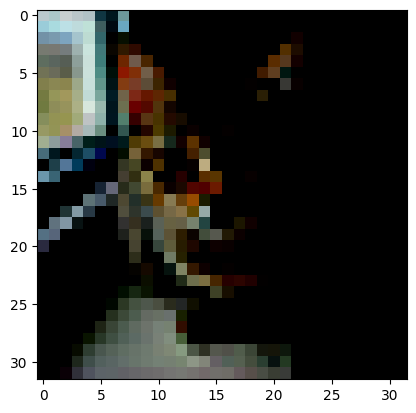

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


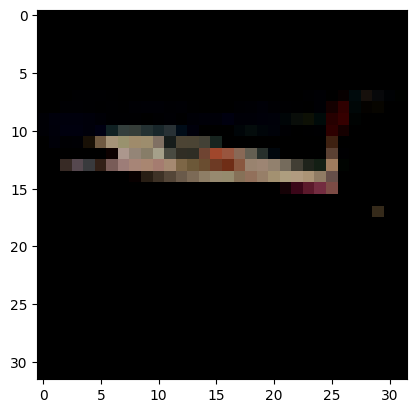

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


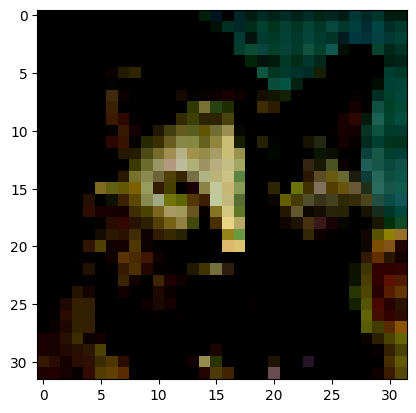

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


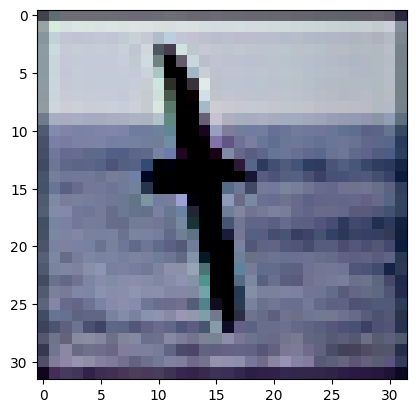

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


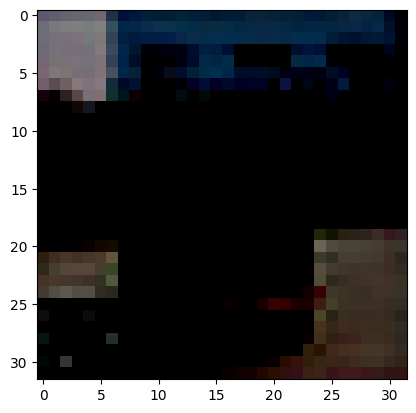

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


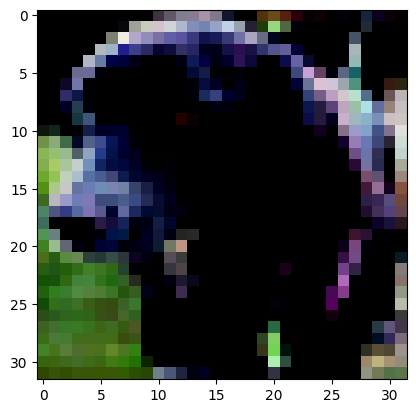

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


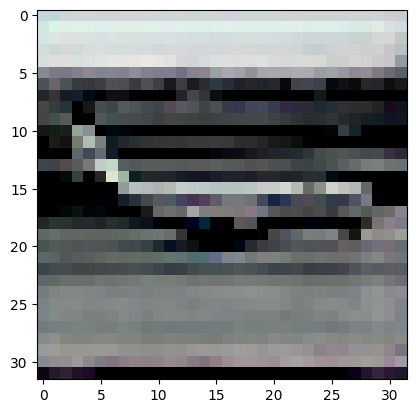

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


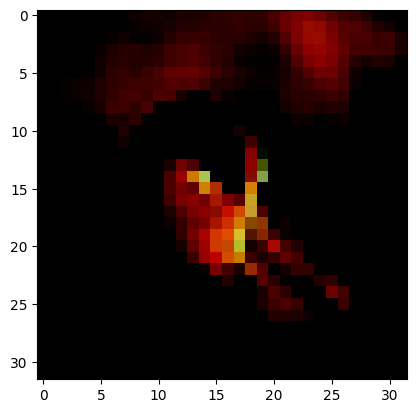

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


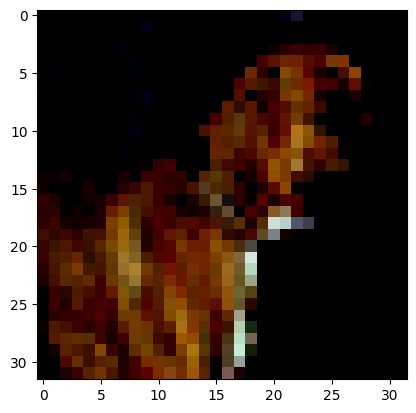

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


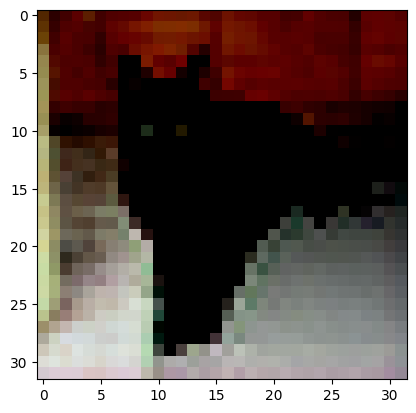

In [103]:
# Assuming `all_image` is a list of images
for x in all_image[:10]:
    # Transpose the axes to match (height, width, channels)
    img = np.transpose(x, (1, 2, 0))
    plt.imshow(img)
    plt.show()


In [104]:
df_auto_fr=pd.DataFrame(opt, columns=['FAKE','REAL'])

In [105]:
df_final = pd.DataFrame({'Filename': all_files_name, 'Predicted Label': all_predicted_labels, 'Probability':df_auto_fr['REAL']})


In [106]:
df_final.to_csv('E:/Autoencoder_pret/ressn_18.csv', index=False)